In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import json
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import ast

In [2]:
ENV_PARAM = "avg_pm2.5"

In [3]:
PARENT = ""
DATA_FOLDER = PARENT + "data_WESCO/"
DATA_FOLDER_READINGS = DATA_FOLDER + "fixed_readings/"
DATA_FOLDER_CACHE = DATA_FOLDER + 'cache/'
CALIBRATION_FOLDER = DATA_FOLDER + "calibration/"


In [4]:
T = 5

In [5]:
room_names = {
    
}

In [6]:
def import_calibration_models():
    with open(CALIBRATION_FOLDER + 'theater_linear.pkl', 'rb') as file:
        m_t = pickle.load(file)
    with open(CALIBRATION_FOLDER + 'showroom_linear.pkl', 'rb') as file:
        m_s = pickle.load(file)
    with open(CALIBRATION_FOLDER + 'davinci_linear.pkl', 'rb') as file:
        m_v = pickle.load(file)

    return m_t, m_s, m_v

In [7]:
#m_t, m_s, m_v = import_calibration_models()
m_t, m_s, m_v = None, None, None

In [8]:
def import_df_from_json(filename, model):
    with open(filename, "r") as file:
        raw_data = json.load(file)

        device_id = raw_data[0]["payload"]["device_id"]
        device_loc = raw_data[0]["payload"]["device_location"]
        room_names[device_id] = device_loc

    
        dataset = [record["payload"]["data"] for record in raw_data if "data" in record["payload"]]
        df = pd.DataFrame(dataset)

        df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int) // 1000, unit='s')
        #df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df = df.drop_duplicates(subset='timestamp')        
        df["device_id"] = device_id
        df["device_location"] = device_loc

        # calibrate
        if model: # no negative results due to miscalibration
            df["avg_pm2.5"] = [max(model.predict(np.array([[x]]))[0], 0) for x in df["avg_pm2.5"]]


    return df    


In [9]:
df1 = import_df_from_json(DATA_FOLDER_READINGS + "theater.json", m_t)
df2 = import_df_from_json(DATA_FOLDER_READINGS + "davinci.json", m_v)
df3 = import_df_from_json(DATA_FOLDER_READINGS + "showroom.json", m_s)
df4 = import_df_from_json(DATA_FOLDER_READINGS + "metcalfe.json", None)


print(f"{df1.shape=} {df2.shape=} {df3.shape=} {df4.shape=}")


df1.shape=(8661, 14) df2.shape=(7048, 14) df3.shape=(6220, 14) df4.shape=(9073, 14)


In [10]:
#FILTER OUT TMS OF VISIT DAYS
all_tms = set(df1['timestamp']) | set(df2['timestamp']) | set(df3['timestamp']) | set(df4['timestamp'])
all_tms = {ts for ts in all_tms if ts.date() not in {pd.Timestamp('2024-07-22'), pd.Timestamp('2024-07-26').date(), pd.Timestamp('2024-07-29').date()}}
# intersection = set(df1['timestamp']) & set(df2['timestamp']) & set(df3['timestamp']) & set(df4['timestamp'])
# print(len(intersection))

In [11]:
def forward_fill_time_limited(df, time_column='timestamp', max_time_diff='60min'):

    F = 0
    filled_df = df.copy()
    
    # Ensure the time column is in datetime format
    filled_df[time_column] = pd.to_datetime(filled_df[time_column])
    
    for column in filled_df.columns:
        if column == time_column:
            continue
        
        last_valid = None
        last_valid_time = None
        
        for i in range(len(filled_df)):
            current_time = filled_df.at[filled_df.index[i], time_column]
            current_value = filled_df.at[filled_df.index[i], column]
            
            if pd.isna(current_value) or (filled_df[column].dtype == 'object' and current_value == ''):
                if (last_valid is not None and 
                    last_valid_time is not None and
                    (current_time - last_valid_time) <= pd.Timedelta(max_time_diff)):
                    
                    filled_df.at[filled_df.index[i], column] = last_valid
                    F += 1
                    
            else:
                last_valid = current_value
                last_valid_time = current_time
    
    #print(F)
    return filled_df


In [12]:
def reindex_df(df):
    df.set_index('timestamp', inplace=True)
    df = df.reindex(all_tms)
    df.sort_index(inplace=True)
    df.reset_index(inplace=True)
    df['status'] = 1 - df['avg_pm2.5'].isna().astype(int)
    df = forward_fill_time_limited(df, time_column='timestamp', max_time_diff='60min')
    print(df.shape)
    df.dropna(inplace=True)
    #print(df.shape)
    return df

df1 = reindex_df(df1)
df2 = reindex_df(df2)
df3 = reindex_df(df3)
df4 = reindex_df(df4)


(9534, 15)
(9534, 15)
(9534, 15)
(9534, 15)


In [13]:
intersection = set(df1['timestamp']) & set(df2['timestamp']) & set(df3['timestamp']) & set(df4['timestamp'])

In [14]:
def combine_dfs(dfs):
    return pd.concat(dfs)

In [15]:
dfs = [df1, df2, df3, df4]
df = combine_dfs(dfs)

In [16]:
_ = df.groupby(['timestamp']).size().reset_index(name='count')

In [17]:
_sorted = _.sort_values(by='count', ascending=False)

In [18]:
_sorted

,timestamp,count
4767,2024-06-04 11:45:00,4
8067,2024-07-12 09:15:00,4
8069,2024-07-12 09:45:00,4
8070,2024-07-12 10:00:00,4
8071,2024-07-12 10:15:00,4
...,...,...
1439,2024-04-23 04:45:00,1
1438,2024-04-23 04:30:00,1
1437,2024-04-23 04:15:00,1
1421,2024-04-22 22:45:00,1


In [19]:
timestamps = _sorted[_sorted['count'] == 4]["timestamp"]
df = df[df['timestamp'].isin(timestamps)]  # === isin(intersection), sanity check

In [20]:
df['timestamp']

73     2024-04-02 17:00:00
89     2024-04-03 03:45:00
90     2024-04-03 04:00:00
91     2024-04-03 04:15:00
92     2024-04-03 04:30:00
               ...        
9245   2024-07-24 21:45:00
9246   2024-07-24 22:00:00
9247   2024-07-24 22:15:00
9248   2024-07-24 22:30:00
9249   2024-07-24 22:45:00
Name: timestamp, Length: 17636, dtype: datetime64[ns]

In [21]:
# extract only timestamps for which we have data for all the sensors
assert timestamps.shape[0] * len(dfs) == df.shape[0]

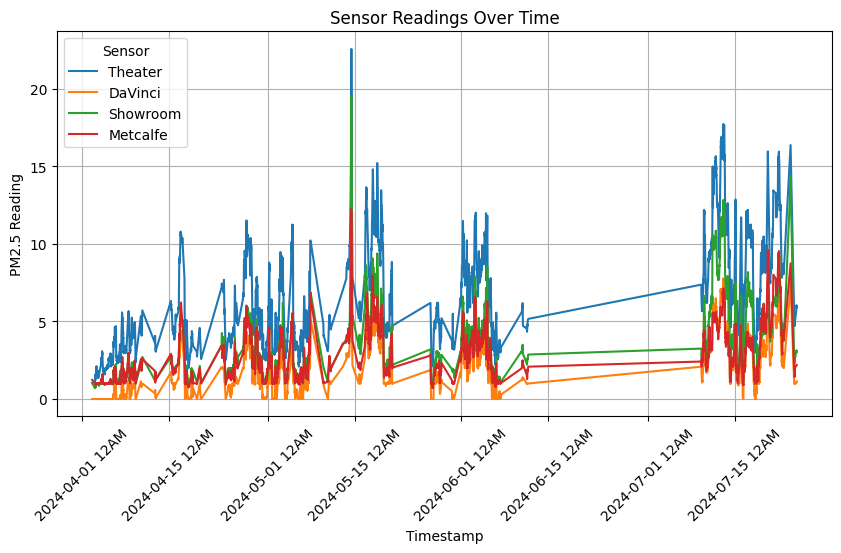

In [22]:
plt.figure(figsize=(10, 5))

# Loop through each site_num and plot its readings
for sensor in df['device_location'].unique():
    subset = df[df['device_location'] == sensor]
    plt.plot(subset['timestamp'], subset['avg_pm2.5'], label=sensor)

# Customize plot

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %I%p'))
plt.title('Sensor Readings Over Time')
plt.xlabel('Timestamp')
plt.xticks(rotation=45)

plt.ylabel('PM2.5 Reading')
plt.legend(title='Sensor')
plt.grid(True)

plt.show()


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17636 entries, 73 to 9249
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        17636 non-null  datetime64[ns]
 1   avg_db           17636 non-null  float64       
 2   avg_rh           17636 non-null  float64       
 3   avg_lux          17636 non-null  float64       
 4   avg_pm1          17636 non-null  float64       
 5   avg_pm4          17636 non-null  float64       
 6   avg_voc          17636 non-null  float64       
 7   avg_eco2         17636 non-null  float64       
 8   avg_pm10         17636 non-null  float64       
 9   avg_temp         17636 non-null  float64       
 10  avg_pm2.5        17636 non-null  float64       
 11  avg_wynd_score   17636 non-null  float64       
 12  device_id        17636 non-null  object        
 13  device_location  17636 non-null  object        
 14  status           17636 non-null  int64     

In [24]:
df

,timestamp,avg_db,avg_rh,avg_lux,avg_pm1,avg_pm4,avg_voc,avg_eco2,avg_pm10,avg_temp,avg_pm2.5,avg_wynd_score,device_id,device_location,status
73,2024-04-02 17:00:00,66.50,33.0,136.311667,1.000000,1.400000,95.916667,463.233333,1.500000,21.0,1.033333,98.0,HAL-007-d532860e,Theater,1
89,2024-04-03 03:45:00,64.55,29.0,97.628333,1.000000,1.316667,45.666667,400.583333,1.483333,18.0,1.150000,98.0,HAL-007-d532860e,Theater,1
90,2024-04-03 04:00:00,64.55,28.0,105.285000,1.000000,1.483333,48.983333,403.500000,1.783333,18.0,1.250000,98.0,HAL-007-d532860e,Theater,1
91,2024-04-03 04:15:00,64.40,28.0,104.548333,0.983333,1.383333,52.816667,405.733333,1.633333,19.0,1.166667,98.0,HAL-007-d532860e,Theater,1
92,2024-04-03 04:30:00,64.35,28.0,104.008333,1.000000,1.733333,55.316667,406.266667,2.083333,19.0,1.350000,98.0,HAL-007-d532860e,Theater,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9245,2024-07-24 21:45:00,63.85,46.0,544.085000,2.000000,3.250000,57.950000,498.350000,4.550000,21.0,2.200000,96.0,HAL-007-470dd483,Metcalfe,1
9246,2024-07-24 22:00:00,63.85,46.0,544.085000,2.000000,3.250000,57.950000,498.350000,4.550000,21.0,2.200000,96.0,HAL-007-470dd483,Metcalfe,0
9247,2024-07-24 22:15:00,63.85,46.0,544.085000,2.000000,3.250000,57.950000,498.350000,4.550000,21.0,2.200000,96.0,HAL-007-470dd483,Metcalfe,0
9248,2024-07-24 22:30:00,63.85,46.0,544.085000,2.000000,3.250000,57.950000,498.350000,4.550000,21.0,2.200000,96.0,HAL-007-470dd483,Metcalfe,0


In [25]:
# FEATURES 
FEATURES = ['device_location', 'timestamp', 'avg_pm2.5', 'status']
columns_to_drop = set(df.columns) - set(FEATURES)
columns_to_drop


{'avg_db',
 'avg_eco2',
 'avg_lux',
 'avg_pm1',
 'avg_pm10',
 'avg_pm4',
 'avg_rh',
 'avg_temp',
 'avg_voc',
 'avg_wynd_score',
 'device_id'}

In [26]:
#df = df.dropna()
df = df.rename(columns={"avg_pm2.5":"pm2_5_avg"})

In [27]:
#df['timestamp'] = pd.to_datetime(df['timestamp'])
#df['year'] = df['timestamp'].dt.year
#df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['dayoftheyear'] = df['timestamp'].dt.dayofyear

In [28]:
SENSOR_COLUMN = 'device_location' # PARAM2

In [29]:
distinctStations = df[SENSOR_COLUMN].unique() 
stationsNumber = distinctStations.shape[0]
print(f"There are {stationsNumber} distinct stations: " + str(distinctStations))
for stationID in distinctStations:
    currentStationNumberRows = df[df[SENSOR_COLUMN] == stationID].shape[0]
    print(f"Station {stationID} has {currentStationNumberRows} elements")

There are 4 distinct stations: ['Theater' 'DaVinci' 'Showroom' 'Metcalfe']
Station Theater has 4409 elements
Station DaVinci has 4409 elements
Station Showroom has 4409 elements
Station Metcalfe has 4409 elements


In [30]:
DATE_COLUMN = 'timestamp' # PARAM3 

In [31]:
dataStartDate = sorted(df[DATE_COLUMN])[0]
dataEndDate = sorted(df[DATE_COLUMN])[-1]
print(f"Dataset has data from {dataStartDate} to {dataEndDate}")

Dataset has data from 2024-04-02 17:00:00 to 2024-07-24 22:45:00


In [32]:
df["device_location"].unique()

array(['Theater', 'DaVinci', 'Showroom', 'Metcalfe'], dtype=object)

In [33]:
locations_placementIds = {
    'DaVinci' : 100,
    'Metcalfe' : 101,
    'Showroom' : 102,
    'Theater' : 103
}

In [34]:
df["placement_id"] = df["device_location"].map(locations_placementIds)

In [35]:
df = df.drop(columns={"device_location"})

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17636 entries, 73 to 9249
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       17636 non-null  datetime64[ns]
 1   avg_db          17636 non-null  float64       
 2   avg_rh          17636 non-null  float64       
 3   avg_lux         17636 non-null  float64       
 4   avg_pm1         17636 non-null  float64       
 5   avg_pm4         17636 non-null  float64       
 6   avg_voc         17636 non-null  float64       
 7   avg_eco2        17636 non-null  float64       
 8   avg_pm10        17636 non-null  float64       
 9   avg_temp        17636 non-null  float64       
 10  pm2_5_avg       17636 non-null  float64       
 11  avg_wynd_score  17636 non-null  float64       
 12  device_id       17636 non-null  object        
 13  status          17636 non-null  int64         
 14  hour            17636 non-null  int32         
 15  minute 

In [37]:
df_selected = df[['timestamp', 'pm2_5_avg', 'status', 'placement_id']]
df_pivoted = df_selected.pivot(index='timestamp', columns='placement_id')

df_pivoted.columns = [f"{col}_{pid}" for col, pid in df_pivoted.columns]
df_pivoted.reset_index(inplace=True)

In [38]:
df_pivoted

,timestamp,pm2_5_avg_100,pm2_5_avg_101,pm2_5_avg_102,pm2_5_avg_103,status_100,status_101,status_102,status_103
0,2024-04-02 17:00:00,0.000000,1.233333,1.033333,1.033333,1,1,1,1
1,2024-04-03 03:45:00,0.000000,1.000000,0.700000,1.150000,1,1,1,1
2,2024-04-03 04:00:00,0.000000,0.983333,0.766667,1.250000,1,1,1,1
3,2024-04-03 04:15:00,0.000000,0.950000,0.716667,1.166667,1,1,1,1
4,2024-04-03 04:30:00,0.000000,0.950000,0.883333,1.350000,1,1,1,1
...,...,...,...,...,...,...,...,...,...
4404,2024-07-24 21:45:00,1.142857,2.200000,3.100000,5.944444,1,1,1,1
4405,2024-07-24 22:00:00,1.142857,2.200000,3.125000,6.038462,0,0,1,1
4406,2024-07-24 22:15:00,1.142857,2.200000,3.050000,5.875000,0,0,1,1
4407,2024-07-24 22:30:00,1.142857,2.200000,3.116667,6.016667,0,0,1,1


In [39]:
df.shape[0] == df_pivoted.shape[0] * 4

True

In [40]:
df = df_pivoted

In [41]:
df = df.rename(columns={"timestamp": "Date", 
                   "placement_id": "Site Num"})
df = df.sort_values(['Date'])

In [42]:
df.to_csv(DATA_FOLDER_CACHE + "WESCO.csv")

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409 entries, 0 to 4408
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           4409 non-null   datetime64[ns]
 1   pm2_5_avg_100  4409 non-null   float64       
 2   pm2_5_avg_101  4409 non-null   float64       
 3   pm2_5_avg_102  4409 non-null   float64       
 4   pm2_5_avg_103  4409 non-null   float64       
 5   status_100     4409 non-null   int64         
 6   status_101     4409 non-null   int64         
 7   status_102     4409 non-null   int64         
 8   status_103     4409 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 310.1 KB
